In [1]:
import os
import re
import json
import random
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
DATA_DIR = Path("data")
RAW_DIR = DATA_DIR / "raw"
MODEL_DIR = Path("models")

In [5]:
NUM_CLASSES = 50
MAX_SAMPLES_PER_CLASS = 60000
BATCH_SIZE = 512
EPOCHS = 20

In [6]:
def ensure_dirs_exist():
    DATA_DIR.mkdir(exist_ok=True)
    RAW_DIR.mkdir(exist_ok=True, parents=True)
    MODEL_DIR.mkdir(exist_ok=True)

In [7]:
ensure_dirs_exist()

In [8]:
def get_all_class_names():
    path = DATA_DIR / 'all_classes.txt'
    
    with path.open('r', encoding='utf-8') as f:
        text = f.read()
    
    classes = re.findall(r'"([^"]+)"', text)
    
    print(f"Found {len(classes)} classes.")
    return classes

In [9]:
def select_random_classes(num_classes=NUM_CLASSES):
    all_classes = get_all_class_names()
    random.seed(7)
    selected_classes = random.sample(all_classes, num_classes)

    with open(DATA_DIR / "selected_classes.json", "w") as f:
        json.dump(selected_classes, f)
    
    print(f"Selected {num_classes} random classes:")
    for i, cls in enumerate(selected_classes[:10]):
        print(f"  {i+1}. {cls}")
    if num_classes > 10:
        print(f"  ... and {num_classes-10} more")
    
    return selected_classes

In [10]:
selected_classes = select_random_classes(NUM_CLASSES)

Found 345 classes.
Selected 50 random classes:
  1. lantern
  2. computer
  3. onion
  4. washing machine
  5. beard
  6. bottlecap
  7. sock
  8. bush
  9. moon
  10. swing set
  ... and 40 more


In [11]:
def download_class_np(class_name):
    url_name = class_name.replace(" ", "%20")
    url = f"https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{url_name}.npy"
    local_file = RAW_DIR / f"{class_name}.npy"
    
    if not local_file.exists():
        print(f"Downloading {class_name}...")
        try:
            urllib.request.urlretrieve(url, local_file)
            print(f"Successfully downloaded {class_name}")
        except Exception as e:
            print(f"Error downloading {class_name}")
    else:
        print(f"File for {class_name} already exists, skipping download")
    
    return local_file

In [12]:
def download_dataset(class_names):
    print(f"\nDownloading {len(class_names)} class files...")
    downloaded_files = []
    
    for class_name in tqdm(class_names, desc="Downloading"):
        file_path = download_class_np(class_name)
        if file_path:
            downloaded_files.append(file_path)
    
    print(f"Downloaded {len(downloaded_files)} class files")
    return downloaded_files

In [13]:
download_dataset(selected_classes)

Downloading: 100%|███████████████████████████| 50/50 [00:00<00:00, 22300.64it/s]

File for lantern already exists, skipping download
File for computer already exists, skipping download
File for onion already exists, skipping download
File for washing machine already exists, skipping download
File for beard already exists, skipping download
File for bottlecap already exists, skipping download
File for sock already exists, skipping download
File for bush already exists, skipping download
File for moon already exists, skipping download
File for swing set already exists, skipping download
File for bicycle already exists, skipping download
File for shoe already exists, skipping download
File for fan already exists, skipping download
File for basketball already exists, skipping download
File for broom already exists, skipping download
File for pig already exists, skipping download
File for peanut already exists, skipping download
File for book already exists, skipping download
File for foot already exists, skipping download
File for bulldozer already exists, skipping down

[PosixPath('data/raw/lantern.npy'),
 PosixPath('data/raw/computer.npy'),
 PosixPath('data/raw/onion.npy'),
 PosixPath('data/raw/washing machine.npy'),
 PosixPath('data/raw/beard.npy'),
 PosixPath('data/raw/bottlecap.npy'),
 PosixPath('data/raw/sock.npy'),
 PosixPath('data/raw/bush.npy'),
 PosixPath('data/raw/moon.npy'),
 PosixPath('data/raw/swing set.npy'),
 PosixPath('data/raw/bicycle.npy'),
 PosixPath('data/raw/shoe.npy'),
 PosixPath('data/raw/fan.npy'),
 PosixPath('data/raw/basketball.npy'),
 PosixPath('data/raw/broom.npy'),
 PosixPath('data/raw/pig.npy'),
 PosixPath('data/raw/peanut.npy'),
 PosixPath('data/raw/book.npy'),
 PosixPath('data/raw/foot.npy'),
 PosixPath('data/raw/bulldozer.npy'),
 PosixPath('data/raw/stairs.npy'),
 PosixPath('data/raw/pencil.npy'),
 PosixPath('data/raw/binoculars.npy'),
 PosixPath('data/raw/stove.npy'),
 PosixPath('data/raw/castle.npy'),
 PosixPath('data/raw/fireplace.npy'),
 PosixPath('data/raw/tree.npy'),
 PosixPath('data/raw/train.npy'),
 PosixPath('

In [14]:
def load_and_preprocess_data(class_names):
    print("\nLoading and preprocessing data...")
    X, y = [], []
    
    for idx, class_name in enumerate(tqdm(class_names, desc="Loading")):
        try:
            file_path = RAW_DIR / f"{class_name}.npy"
            class_data = np.load(file_path)
            
            if len(class_data) > MAX_SAMPLES_PER_CLASS:
                indices = np.random.choice(len(class_data), MAX_SAMPLES_PER_CLASS, replace=False)
                class_data = class_data[indices]
            
            class_data = class_data.astype("float32") / 255.0

            X.append(class_data)
            y.append(np.full(len(class_data), idx, dtype="int32"))
            
        except Exception as e:
            print(f"Error loading {class_name}: {e}")
    
    X = np.concatenate(X)
    y = np.concatenate(y)
    
    print(f"Total samples: {X.shape[0]}")

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42)
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
    
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_val = X_val.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1)
    
    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [15]:
X_train, X_val, X_test, y_train, y_val, y_test = load_and_preprocess_data(selected_classes)


Loading and preprocessing data...


Loading: 100%|██████████████████████████████████| 50/50 [00:07<00:00,  6.64it/s]


Total samples: 3000000
Train set: 2400000 samples
Validation set: 300000 samples
Test set: 300000 samples


In [20]:
def build_model(num_classes=NUM_CLASSES):
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.25),
        
        # Fully connected layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [21]:
model = build_model(NUM_CLASSES)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 341,650 (1.30 MB)

 Trainable params: 340,946 (1.30 MB)

 Non-trainable params: 704 (2.75 KB)

In [22]:
def train_model(model, X_train, y_train, X_val, y_val):
    print("\nTraining model...")
    
    # Define callbacks
    callbacks = [
        ReduceLROnPlateau(factor=0.3, patience=3, min_lr=1e-6, verbose=1),
        EarlyStopping(patience=5, restore_best_weights=True, verbose=1)
    ]
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )
    
    return history

In [23]:
history = train_model(model, X_train, y_train, X_val, y_val)


Training model...
Epoch 1/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 888s 189ms/step - accuracy: 0.6469 - loss: 1.3557 - val_accuracy: 0.8331 - val_loss: 0.6181 - learning_rate: 0.0010
Epoch 2/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 1124s 240ms/step - accuracy: 0.7943 - loss: 0.7652 - val_accuracy: 0.8421 - val_loss: 0.5821 - learning_rate: 0.0010
Epoch 3/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 908s 194ms/step - accuracy: 0.8080 - loss: 0.7152 - val_accuracy: 0.8501 - val_loss: 0.5549 - learning_rate: 0.0010
Epoch 4/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 868s 185ms/step - accuracy: 0.8146 - loss: 0.6908 - val_accuracy: 0.8540 - val_loss: 0.5404 - learning_rate: 0.0010
Epoch 5/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 871s 186ms/step - accuracy: 0.8191 - loss: 0.6742 - val_accuracy: 0.8559 - val_loss: 0.5322 - learning_rate: 0.0010
Epoch 6/20
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 870s 186ms/step - accuracy: 0.8217 - loss: 0.6637 - val_accuracy: 0.8578 - val_loss: 0.5263 - learning_rate: 0.0010
Epoch 7/20
4688/4688 ━━━━━━━━━━━

In [24]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()

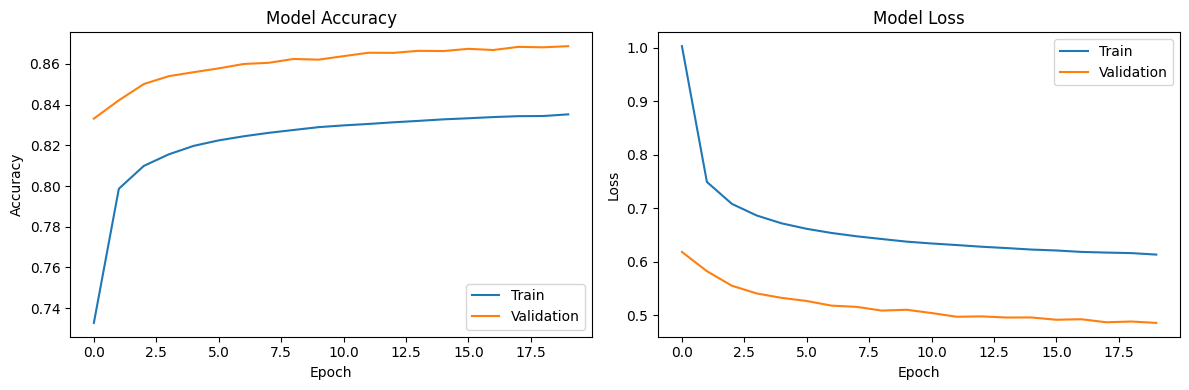

In [25]:
plot_learning_curves(history)

In [26]:
def evaluate_model(model, X_test, y_test, class_names):
    print("\nEvaluating model...")
    
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}")
    
    # Generate predictions
    y_pred = np.argmax(model.predict(X_test), axis=1)
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 12))
    cm = confusion_matrix(y_test, y_pred)
    
    # Use abbreviated class names for better visualization
    short_names = [name[:10] + "..." if len(name) > 10 else name for name in class_names]
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=short_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    
    # Plot some example predictions
    plt.figure(figsize=(12, 8))
    for i in range(15):  # Show 15 examples
        plt.subplot(3, 5, i + 1)
        plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
        pred_idx = y_pred[i]
        true_idx = y_test[i]
        title = f"True: {class_names[true_idx]}\nPred: {class_names[pred_idx]}"
        plt.title(title, fontsize=8)
        plt.axis('off')
    plt.tight_layout()


Evaluating model...
Test accuracy: 0.8677
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step


<Figure size 1200x1200 with 0 Axes>

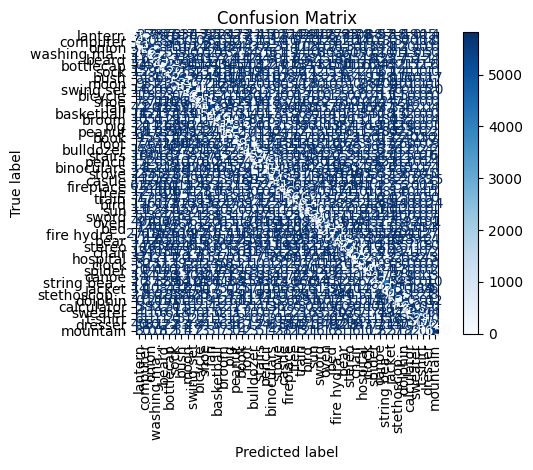

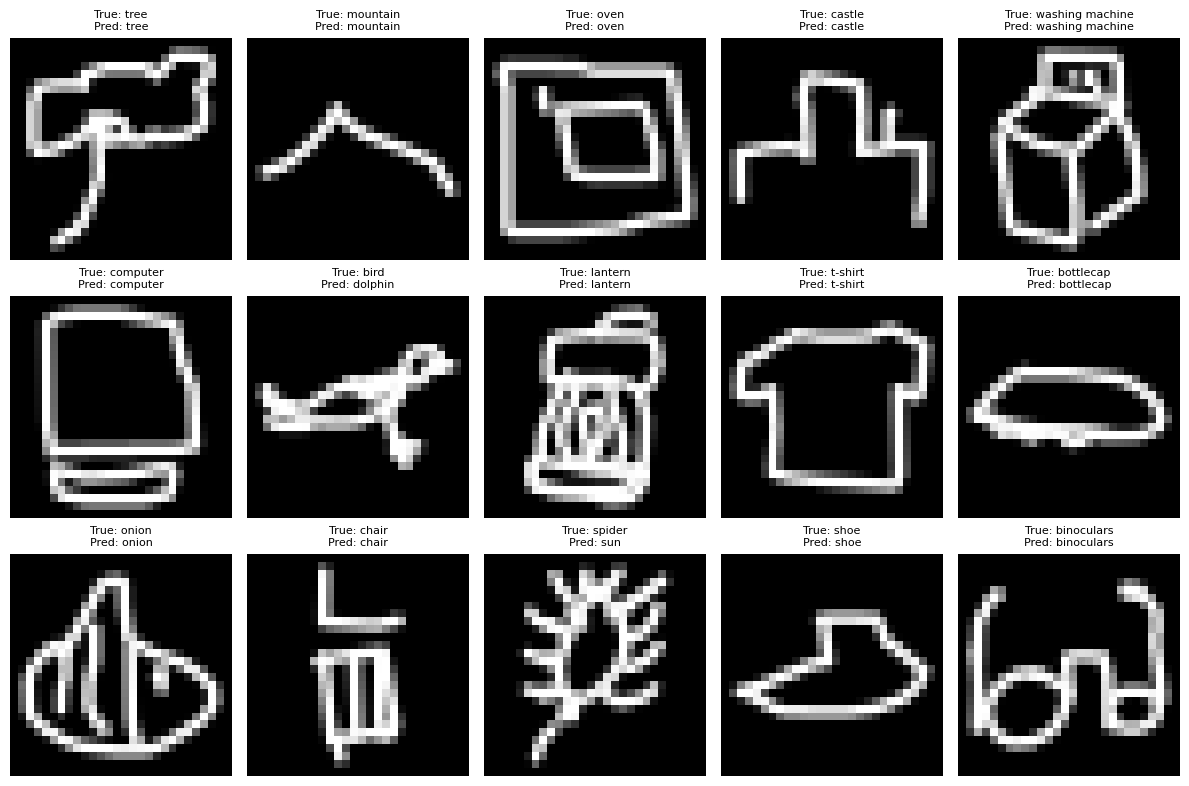

In [27]:
evaluate_model(model, X_test, y_test, selected_classes)

In [28]:
def save_model(model):
    model_path = MODEL_DIR / "quick_draw_model.h5"
    model.save(model_path, save_format="h5")
    print(f"\nModel saved to {model_path}")

In [29]:
save_model(model)


Model saved to models/quick_draw_model.h5
